Nama : Iklima Mardiana

Dataset : https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis

In [3]:
# dataframe
import pandas as pd
import re

# split data
from sklearn.model_selection import train_test_split

# preprocessing dan layer
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM,Dense,Embedding,Dropout,Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# visualisasi plot
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('twitter_sentiment.csv')
df = df.drop(columns=['Borderlands', '2401'])
df = df.rename(columns={'Positive': 'category', 'im getting on borderlands and i will murder you all ,': 'text'})
df

,category,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
53821,Negative,@ CfDuty fix their game new omg challenge with...
53822,Negative,@CallofDuty fix your game new omg challenge re...
53823,Negative,Dear @CallofDuty fix your stupid game new omg ...
53824,Negative,@CallofDuty fix your game new omg challenge cu...


In [5]:
# Menghapus nilai NaN
df.isnull().values.any()
df = df.dropna(subset=['category', 'text'], how='any')

In [6]:
# # Menghapus special character di kolom text
df['text'] = df['text'].map(lambda x: re.sub(r'\W+', ' ', x))
df

<ipython-input-6-50ea6a6e2956>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = df['text'].map(lambda x: re.sub(r'\W+', ' ', x))


,category,text
0,Positive,I am coming to the borders and I will kill you...
1,Positive,im getting on borderlands and i will kill you ...
2,Positive,im coming on borderlands and i will murder you...
3,Positive,im getting on borderlands 2 and i will murder ...
4,Positive,im getting into borderlands and i can murder y...
...,...,...
53821,Negative,CfDuty fix their game new omg challenge witho...
53822,Negative,CallofDuty fix your game new omg challenge re...
53823,Negative,Dear CallofDuty fix your stupid game new omg c...
53824,Negative,CallofDuty fix your game new omg challenge cu...


In [7]:
# melakukan one-hot-encoding

category = pd.get_dummies(df.category)
df_baru = pd.concat([df, category], axis=1)
df_baru = df_baru.drop(columns='category')
df_baru

,text,Irrelevant,Negative,Neutral,Positive
0,I am coming to the borders and I will kill you...,0,0,0,1
1,im getting on borderlands and i will kill you ...,0,0,0,1
2,im coming on borderlands and i will murder you...,0,0,0,1
3,im getting on borderlands 2 and i will murder ...,0,0,0,1
4,im getting into borderlands and i can murder y...,0,0,0,1
...,...,...,...,...,...
53821,CfDuty fix their game new omg challenge witho...,0,1,0,0
53822,CallofDuty fix your game new omg challenge re...,0,1,0,0
53823,Dear CallofDuty fix your stupid game new omg c...,0,1,0,0
53824,CallofDuty fix your game new omg challenge cu...,0,1,0,0


In [8]:
# mengubah nilai-nilai dari dataframe ke dalam tipe data numpy array menggunakan atribut values

text = df_baru['text'].astype(str)
label = df_baru[['Irrelevant',	'Negative',	'Neutral',	'Positive']].values

In [9]:
# membagi data untuk training dan data testing

text_train, text_test, label_train, label_test = train_test_split(text, label, test_size=0.2)

In [10]:
# mengubah setiap kata pada dataset ke dalam bilangan numerik dengan fungsi Tokenizer

tokenizer = Tokenizer(num_words=5000, oov_token='x')
tokenizer.fit_on_texts(text_train)
tokenizer.fit_on_texts(text_test)

sekuens_train = tokenizer.texts_to_sequences(text_train)
sekuens_test = tokenizer.texts_to_sequences(text_test)

max_sequence_length = 66
padded_train = pad_sequences(sekuens_train, maxlen=max_sequence_length)
padded_test = pad_sequences(sekuens_test, maxlen=max_sequence_length)

In [31]:
# arsitektur model dengan menggunakan layer Embedding

model = Sequential([
    Embedding(input_dim=5000, output_dim=16, input_length=max_sequence_length),
    Bidirectional(LSTM(128)),
    Dense(2048, activation='relu'),
    Dropout(0.5),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

# Model compiile dengan optimizer Adam

model.compile(loss='categorical_crossentropy',optimizer=tf.optimizers.Adam(learning_rate=0.0001),metrics=['accuracy'])

In [25]:
# Penggunaan callback untuk accuracy dan val diatas 90%

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.86 and logs.get('val_accuracy')>0.86):
      print("\nAkurasi train dan validasi didapat telah mencapai nilai > 86%!")
      self.model.stop_training = True
callbacks = myCallback()


In [32]:
# melatih model

history = model.fit(
    padded_train,
    label_train,
    epochs=100,
    validation_data=(padded_test, label_test),
    batch_size=128,
    verbose=2,
    callbacks=[callbacks])

Epoch 1/100
334/334 - 26s - loss: 1.3745 - accuracy: 0.2827 - val_loss: 1.3515 - val_accuracy: 0.2961 - 26s/epoch - 77ms/step
Epoch 2/100
334/334 - 9s - loss: 1.3193 - accuracy: 0.3359 - val_loss: 1.2679 - val_accuracy: 0.3918 - 9s/epoch - 26ms/step
Epoch 3/100
334/334 - 7s - loss: 1.2341 - accuracy: 0.3998 - val_loss: 1.1803 - val_accuracy: 0.4253 - 7s/epoch - 20ms/step
Epoch 4/100
334/334 - 5s - loss: 1.1654 - accuracy: 0.4276 - val_loss: 1.1424 - val_accuracy: 0.4454 - 5s/epoch - 16ms/step
Epoch 5/100
334/334 - 5s - loss: 1.1215 - accuracy: 0.4538 - val_loss: 1.1214 - val_accuracy: 0.4665 - 5s/epoch - 15ms/step
Epoch 6/100
334/334 - 5s - loss: 1.0912 - accuracy: 0.4749 - val_loss: 1.1057 - val_accuracy: 0.4763 - 5s/epoch - 16ms/step
Epoch 7/100
334/334 - 5s - loss: 1.0626 - accuracy: 0.4944 - val_loss: 1.0839 - val_accuracy: 0.4939 - 5s/epoch - 16ms/step
Epoch 8/100
334/334 - 5s - loss: 1.0392 - accuracy: 0.5138 - val_loss: 1.0698 - val_accuracy: 0.5057 - 5s/epoch - 15ms/step
Epoch 

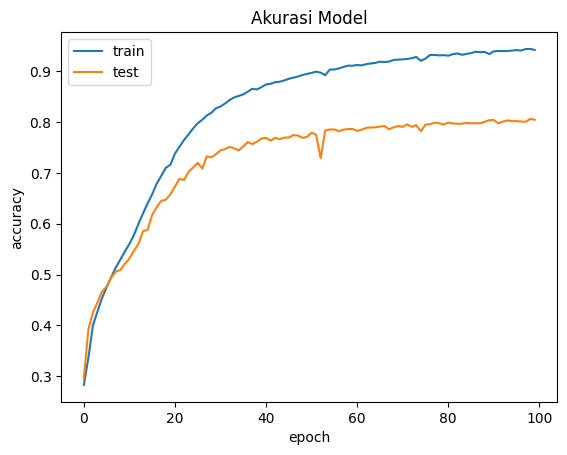

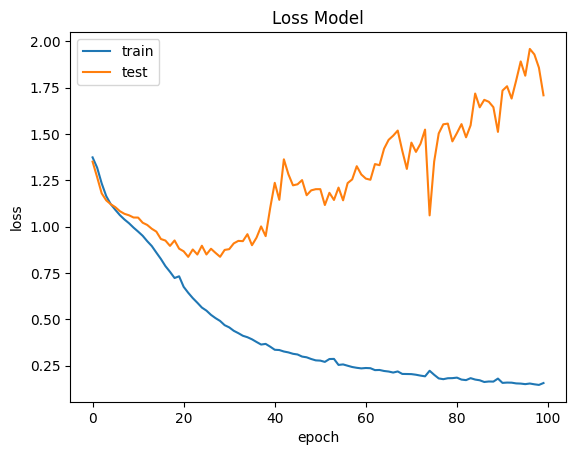

In [33]:

# Plot Accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Plot Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()